In [1]:
import shadow_reconstruction
import qutip as qt
import numpy
from matplotlib import pyplot
import os

In [2]:
def make_perms(n):
    return itertools.permutations(numpy.arange(n))

def gen_cliffords():
    yield from qt.qubit_clifford_group()


def get_num_cons_cliffords():
    def f(x):
        y = numpy.eye(4, dtype=numpy.complex128)
        y[1:3, 1:3] = x
        return y
    return {
        k: f(v.__array__()) for k, v in enumerate(gen_cliffords())
    }

In [3]:
cliffords = numpy.array(list(get_num_cons_cliffords().values()))

/tmp/ipykernel_8359/2038288818.py:5: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  yield from qt.qubit_clifford_group()


In [54]:
# (01 + 10)00
l = 16
zz = numpy.zeros((1, 1<<l), dtype=numpy.complex128)
zz[0, 1] = 1.0
# zz /= numpy.linalg.norm(zz)
# rho = zz.T @ zz
# # print(numpy.trace(rho))
# rho /= numpy.trace(rho)
# rho = shadow_reconstruction.DensityMatrix.new_mixed_sparse(rho.astype(numpy.complex128))
# rho.expectation_string('Z' + 'I'*7), rho.expectation_string('ZIZ' + 'I'*5)

In [55]:
rho = shadow_reconstruction.DensityMatrix.new_pure_dense(zz[0,:].astype(numpy.complex128))
rho.expectation_string('I'*(l-1) + 'Z')

(-1+0j)

In [56]:
N = 100_000

exp = shadow_reconstruction.Experiment(l, ops=cliffords)
print("Sampling...")
samples = exp.sample(rho, N)
print("Saving...")
samples.save_to('larger_samples_pure.dat')

Sampling...
Saving...


In [45]:
def est_str(opstr, rho, samples, subsets, trials=1000):
    tru = rho.expectation_string(opstr)
    
    xaxis = []
    mdata = []
    sdata = []
    
    for sub in subsets:
        sub = int(sub)
        xaxis.append(sub)
        subdat = []
        for _ in range(trials):
            est = recon.estimate_string(opstr, samples.subset(sub))
            subdat.append(est - tru)
        m = numpy.mean(subdat)
        s = numpy.std(subdat)/trials
        mdata.append(m)
        sdata.append(s)
    return numpy.array(mdata), numpy.array(sdata)

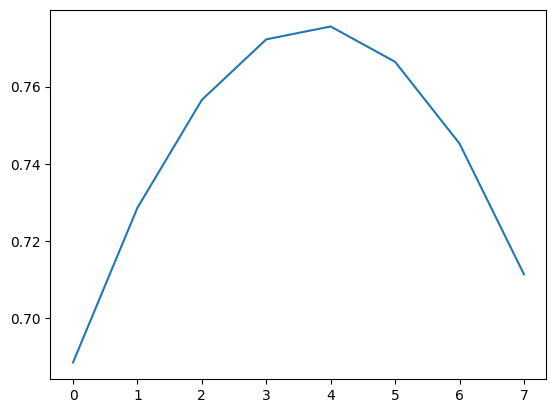

In [59]:
recon = shadow_reconstruction.Reconstruction()

std_data = []
for i in range(1,l//2 + 1):
    opstr = 'I'*(l-i) + 'Z'*i
    
    tru = rho.expectation_string(opstr)
    
    ests_diffs = recon.estimate_string_for_each_sample(opstr, samples) - tru
    std_diffs = numpy.sqrt((numpy.conj(ests_diffs) * ests_diffs).real).mean()
    std_data.append(std_diffs)
pyplot.plot(std_data)